---
# **Preparation**
---

**Common**

In [88]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np


class Common:
    @staticmethod
    def key_value_swap(dataset):
        input = dataset.get_word_index()
        return dict([(value, key) for (key, value) in input.items()])

    """
    =================================================================================
    Data Manipulation Functions
    =================================================================================
    """

    @staticmethod
    def decode_data(dataset, input: list):
        dictionary = Common.key_value_swap(dataset)
        return [dictionary[i] for i in input]

    @staticmethod
    def encode_data(input_samples, dimension):
        """
        Samples:
        - Length of each review is not uniform
        - Use one-hot encoding to have a uniform review length
        """
        output_samples = np.zeros(shape=(len(input_samples), dimension))
        for sample_index, sample in enumerate(input_samples):
            for word_index in sample:
                output_samples[sample_index][word_index] = 1
        return output_samples

    @staticmethod
    def shuffle_data(input_samples, input_labels):
        num_val = int(0.3 * len(input_samples))
        shuffle_indices = np.random.permutation(len(input_samples))
        output_samples = input_samples[shuffle_indices]
        output_labels = input_labels[shuffle_indices]
        return num_val, output_samples, output_labels

    """
    =================================================================================
    Train/Val Split Functions
    =================================================================================
    """

    @staticmethod
    def train_val_data(samples, labels, percent=0.3):
        # Shuffle Data
        num_val = int(percent * len(samples))
        shuffle_indices = np.random.permutation(len(samples))
        samples = samples[shuffle_indices]
        labels = labels[shuffle_indices]
        # Training and validation dataset
        x_train = samples[num_val:]
        y_train = labels[num_val:]
        x_val = samples[:num_val]
        y_val = labels[:num_val]
        # Dataset
        return x_train, y_train, x_val, y_val

    @staticmethod
    def train_val_data_kfold(data, fold_count, fold_size):
        """
        Note: Data must be numpy arrays, not python array
        """
        val = data[fold_count * fold_size : (fold_count + 1) * fold_size]
        train = np.concatenate(
            [
                # Pre Validation Fold
                data[: fold_count * fold_size],
                # Post Validation Fold
                data[(fold_count + 1) * fold_size :],
            ],
            axis=0,
        )
        return train, val

    @staticmethod
    def explore_k_fold():
        data = np.array(
            [
                np.array([1, 2, 3]),
                np.array([4, 5, 6]),
                np.array([7, 8, 9]),
                np.array([10, 11, 12]),
                np.array([13, 14, 15]),
            ]
        )
        n = 4
        size = len(data) // n
        for index in range(n):
            Common.train_val_data_kfold(data, index, size)

    """
    =================================================================================
    History Functions
    =================================================================================
    """

    @staticmethod
    def save_history(histories, history):
        """
        histories: History of all epochs of all folds
        history:   History of current epoch of current fold
        """
        histories["loss"].append(history["loss"])
        histories["val_loss"].append(history["val_loss"])
        histories["mean_absolute_error"].append(history["mean_absolute_error"])
        histories["val_mean_absolute_error"].append(history["val_mean_absolute_error"])

    @staticmethod
    def get_history(history, type, num_ignore=20):
        # MAE per epoch
        mae = history["mean_absolute_error"][num_ignore:]
        val_mae = history["val_mean_absolute_error"][num_ignore:]
        print("Mean Training MAE: ", np.mean(mae))
        print("Mean Validation MAE: ", np.mean(val_mae))
        plt.title("MAE per epoch: {}".format(type))
        plt.plot(mae, "b")
        plt.plot(val_mae, "r")
        plt.show()

    @staticmethod
    def mean_history(histories):
        """
        Function:
        -------------------------------------------------------------------
        - Mean of all folds per epoch

        Example:
        -------------------------------------------------------------------
        - Loss = [
        [[Epoch1_Fold1], [Epoch1_Fold2], [Epoch1_Fold3], [Epoch1_Fold4]],
        [[Epoch2_Fold1], [Epoch2_Fold2], [Epoch2_Fold3], [Epoch2_Fold4]],
        ...
        ]

        Note:
        -------------------------------------------------------------------
        - Dataset needs to be transposed. Because:
            Given:    Metric per fold per epoch
            Required: Metric per epoch per fold
        - First fold is ignored because its results are always unstable (reason not known)
        """
        history = {
            "loss": [],
            "val_loss": [],
            "mean_absolute_error": [],
            "val_mean_absolute_error": [],
        }
        m1 = np.array(histories["loss"][1:]).transpose()
        m2 = np.array(histories["val_loss"][1:]).transpose()
        m3 = np.array(histories["mean_absolute_error"][1:]).transpose()
        m4 = np.array(histories["val_mean_absolute_error"][1:]).transpose()
        history = {
            "loss": [np.mean(loss_per_fold) for loss_per_fold in m1],
            "val_loss": [np.mean(loss_per_fold) for loss_per_fold in m2],
            "mean_absolute_error": [np.mean(loss_per_fold) for loss_per_fold in m3],
            "val_mean_absolute_error": [np.mean(loss_per_fold) for loss_per_fold in m4],
        }
        return history

    """
    =================================================================================
    Training Exploration Functions
    =================================================================================
    """

    @staticmethod
    def explore(train_loss, train_accuracy, val_loss, val_accuracy):
        print("Training Loss: ", train_loss[-1])
        print("Training Accuracy: ", train_accuracy[-1])
        print("Validation Loss: ", val_loss[-1])
        print("Validation Accuracy: ", val_accuracy[-1])

        plt.title("Training and validation loss")
        plt.plot(train_loss, "b")
        plt.plot(val_loss, "r")
        plt.show()

        plt.title("Training and validation accuracy")
        plt.plot(train_accuracy, "b")
        plt.plot(val_accuracy, "r")
        plt.show()

---
# **Binary Classification**
---

**Description**

| Topic | Detail |
| --- | --- |
| Dataset | IMDB: Reviews of movies with a score for each movie |
| Sample | Review (each word has a unique number) |
| Last Activation | Sigmoid (Units=1) |
| Loss | BinaryCrossentropy |
| Optimizer | RMSprop |
| Metric | BinaryAccuracy |
| Units | Output size of layer. Defines how much info can be captured |


**Dataset**

In [89]:
num_words = 10000
imdb = tf.keras.datasets.imdb
(x_train_og, y_train_og), (x_test_og, y_test_og) = imdb.load_data(num_words=num_words)

**Exploration**

In [90]:
print(Common.decode_data(imdb, [999, 19, 1000]))

['cop', 'film', 'secret']


**Encoding**

In [91]:
x_train = Common.encode_data(x_train_og, num_words)
y_train = np.asarray(y_train_og).astype(np.float32)

x_test = Common.encode_data(x_test_og, num_words)
y_test = np.asarray(y_test_og).astype(np.float32)

**Validation**

In [92]:
x_train, y_train, x_val, y_val = Common.train_val_data(x_train, y_train)

**Model**

In [93]:
learning_rate = 1e-4
epochs = 10


def get_model():
    # Create the model
    # Output: Probability
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(units=32, activation=tf.nn.relu),
            tf.keras.layers.Dense(units=32, activation=tf.nn.relu),
            tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid),
        ]
    )

    # Configure the model
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy()],
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
    )

    return model

**Training**

In [94]:
model = get_model()
history = model.fit(
    x=x_train, y=y_train, epochs=epochs, validation_data=(x_val, y_val), verbose=False
)

**Exploration**

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Training Loss:  0.11748116463422775
Training Accuracy:  0.9598285555839539
Validation Loss:  0.3135225474834442
Validation Accuracy:  0.8844000101089478


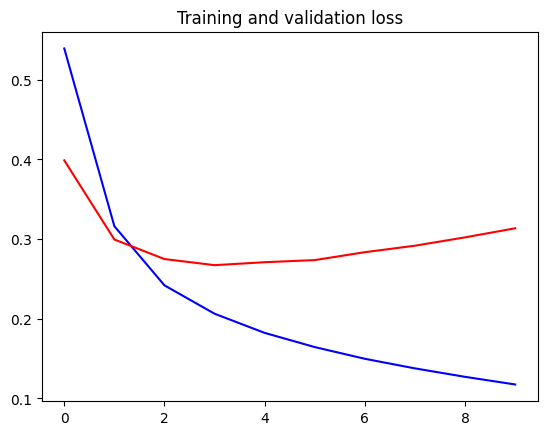

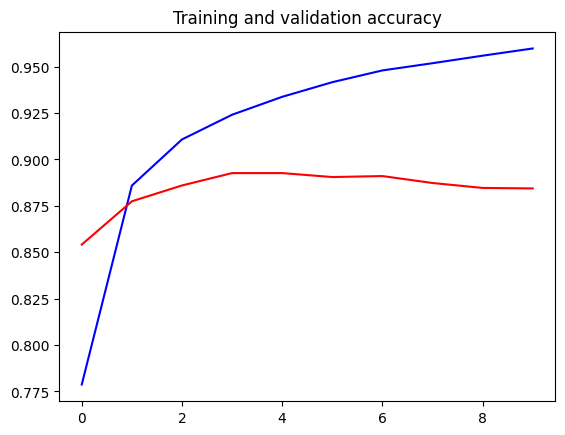

In [95]:
print(history.history.keys())

train_loss = history.history["loss"]
train_accuracy = history.history["binary_accuracy"]
val_loss = history.history["val_loss"]
val_accuracy = history.history["val_binary_accuracy"]

Common.explore(train_loss, train_accuracy, val_loss, val_accuracy)

**Evaluation**

In [96]:
evaluation = model.evaluate(x=x_test, y=y_test)
print(model.metrics_names)

782/782 [==============================] - 0s 432us/step - loss: 0.3392 - binary_accuracy: 0.8773
['loss', 'binary_accuracy']


**Prediction**

In [97]:
# Prediction: Probability that a review is positive
y_predict = model.predict(x_test)[:, 0]

782/782 [==============================] - 0s 418us/step


---
# **Muticlass Classification**
---

**Description**

| Topic | Detail |
|--- | --- |
| Dataset | Reuters: Newswires with a topic for each newswire |
| Sample | Newswire (each word has a unique number) |
| Target | Topics (46) |
| Last Activation | Softmax (Units=46) |
| Loss | CategoricalCrossentropy |
| Optimizer | RMSprop |
| Metric | CategoricalAccuracy |
| Note | Units in hidden layers should **always be more** than last layer |

**Dataset**

In [98]:
num_words = 10000

reuters = tf.keras.datasets.reuters
(x_train_og, y_train_og), (x_test_og, y_test_og) = reuters.load_data(
    num_words=num_words
)

**Exploration**

In [99]:
print(Common.decode_data(reuters, [999, 19, 1000]))

['totalled', 'from', 'limit']


**Encoding**

In [100]:
x_train = Common.encode_data(x_train_og, num_words)
y_train = tf.keras.utils.to_categorical(y_train_og)

x_test = Common.encode_data(x_test_og, num_words)
y_test = tf.keras.utils.to_categorical(y_test_og)

**Alternate Encoding**

In [101]:
"""
Use SparseCategoricalCrossentropy as a loss function
"""
y_train_alternate = np.array(y_train_og)
y_test_alternate = np.array(y_test_og)

**Validation**

In [102]:
x_train, y_train, x_val, y_val = Common.train_val_data(x_train, y_train)

**Model**

In [103]:
learning_rate = 1e-4
epochs = 10


def get_model():
    # Create the model
    # Output: Probability Distribution
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(units=512, activation=tf.nn.relu),
            tf.keras.layers.Dense(units=512, activation=tf.nn.relu),
            tf.keras.layers.Dense(units=46, activation=tf.nn.softmax),
        ]
    )

    # Configure the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy()],
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
    )
    return model

**Training**

In [104]:
model = get_model()
history = model.fit(
    x=x_train, y=y_train, epochs=epochs, validation_data=(x_val, y_val), verbose=False
)

**Exploration**

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])
Training Loss:  0.21928465366363525
Training Accuracy:  0.9495865106582642
Validation Loss:  0.8956505656242371
Validation Accuracy:  0.8103192448616028


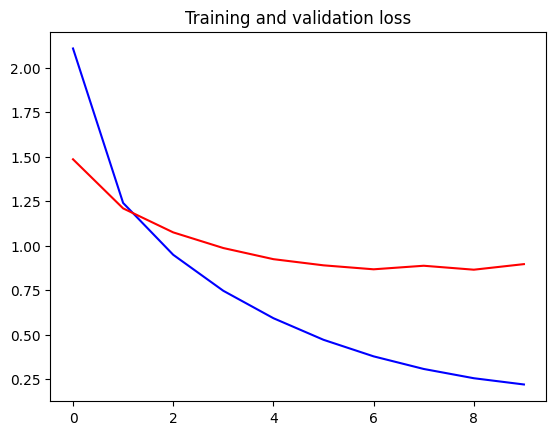

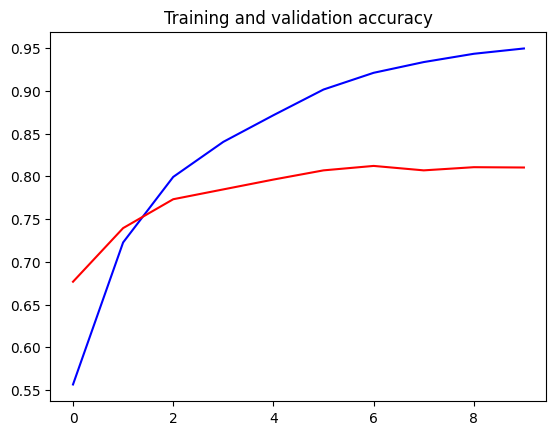

In [105]:
print(history.history.keys())

train_loss = history.history["loss"]
train_accuracy = history.history["categorical_accuracy"]
val_loss = history.history["val_loss"]
val_accuracy = history.history["val_categorical_accuracy"]

Common.explore(train_loss, train_accuracy, val_loss, val_accuracy)

**Evaluation**

In [106]:
evaluation = model.evaluate(x=x_test, y=y_test, verbose=False)
print("Evaluation Loss: ", evaluation[0])
print("Evaluation Accuracy: ", evaluation[1])

Evaluation Loss:  0.9736537933349609
Evaluation Accuracy:  0.7867319583892822


**Prediction**

In [107]:
y_predict = model.predict(x_test)
for predict, ground in zip(y_predict[:5], y_test[:5]):
    print("----------------------------------------------")
    print("True: {}".format(np.argmax(ground)))
    print("Pred: {}".format(np.argmax(predict)))
    print("Confidence: {}%".format(int(max(predict) * 100)))

71/71 [==============================] - 0s 2ms/step
----------------------------------------------
True: 3
Pred: 3
Confidence: 98%
----------------------------------------------
True: 10
Pred: 10
Confidence: 98%
----------------------------------------------
True: 1
Pred: 1
Confidence: 90%
----------------------------------------------
True: 4
Pred: 16
Confidence: 72%
----------------------------------------------
True: 4
Pred: 13
Confidence: 99%


---
# **Scalar Regression**
---

**Description**

| Topic | Detail |
|--- | --- |
| Dataset | Boston housing prices given features e.g. crime rate, tax rate etc. |
| Sample | Features (13) of a house |
| Target | Price (1) of a house |
| Last Activation | None (Units=1) |
| Loss | MeanSquaredError |
| Optimizer | RMSprop |
| Metric | MeanAbsoluteError |
| Logistic Regression | Not same as Scalar Regression. A type of classification |
| Linear Regression | Type of Scalar Regression |
| Non-uniform scaling | Each feature has a different scale  |
| Feature-wise normalization | Features must be centered around 0 with unit standard deviation |

**Dataset**

In [108]:
(samples, labels), (
    test_samples,
    test_labels,
) = tf.keras.datasets.boston_housing.load_data()

**Feature-wise Normalization**

In [109]:
# Samples are centered arond 0
mean = samples.mean(axis=0)
samples -= mean

# Samples have unit standard deviation
std = samples.std(axis=0)
samples /= std

# Test dataset (using mean/std from samples)
test_samples -= mean
test_samples /= std

**Model**

In [110]:
epochs = 120


def get_model():
    # Output: Continuous Value
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(units=96, activation=tf.nn.relu),
            tf.keras.layers.Dense(units=96, activation=tf.nn.relu),
            tf.keras.layers.Dense(units=1, activation=None),
        ]
    )

    # Configure the model
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
        optimizer=tf.keras.optimizers.legacy.RMSprop(),
    )
    return model


def get_prediction(input_model, type, num_predict=3):
    y_predict = input_model.predict(test_samples, verbose=False)
    print()
    print("==================================================")
    print(type)
    print("==================================================")
    print()
    for predict, ground in zip(y_predict[:num_predict], test_labels[:num_predict]):
        print("Ground: {} Predict: {}".format(ground, predict[0]))
        print("Error: {}".format(abs(ground - predict[0])))
        print()


def get_evaluation(input_model, type):
    _, test_mae_score = input_model.evaluate(test_samples, test_labels, verbose=False)
    print("Mean Test MAE ({}): {}".format(type, test_mae_score))

### <ins>**01. Training with Standard Split**</ins>

**Train / Val Dataset**

In [111]:
train_samples, train_labels, val_samples, val_labels = Common.train_val_data(
    samples, labels, 0.3
)

**Training**

In [118]:
standard_model = get_model()
standard_history = standard_model.fit(
    x=train_samples,
    y=train_labels,
    epochs=epochs,
    validation_data=(val_samples, val_labels),
    verbose=False,
)

**Summary**

- When the dataset is very small, normal train/val division (70% / 30%) does not work good
- K-Fold Cross-Validation is the recommended method


### <ins>**02. Training with K-Fold Cross-Validation**</ins>

  **Explanation**
  - Divide dataset into multiple small folds
  - This way whole dataset is used for training as well as  validation
  - Take the mean after all iterations

**Example**

In [113]:
"""
Note: Run the snippet in debugger mode with breakpoint in the k-fold function
"""
Common.explore_k_fold()

**Training**

In [127]:
num_fold = 10
fold_size = len(samples) // num_fold

# History per fold per epoch
histories = {
    "loss": [],
    "val_loss": [],
    "mean_absolute_error": [],
    "val_mean_absolute_error": [],
}

# Training per fold
for fold_count in range(num_fold):
    # Samples using K-Fold
    train_samples, val_samples = Common.train_val_data_kfold(
        samples, fold_count, fold_size
    )
    # Labels using K-Fold
    train_labels, val_labels = Common.train_val_data_kfold(
        labels, fold_count, fold_size
    )
    # New model per fold
    kfold_model = get_model()
    # Training
    history_per_epoch = kfold_model.fit(
        x=train_samples,
        y=train_labels,
        epochs=epochs,
        validation_data=(val_samples, val_labels),
        verbose=False,
    )
    # Save history per epoch per fold
    Common.save_history(histories, history_per_epoch.history)

# Mean history of all fold for each epoch
kfold_history = Common.mean_history(histories)

### **03. Comparison of Standard and K-Fold**

**Exploration**

Mean Training MAE:  1.869376757144928
Mean Validation MAE:  2.2429565834999083


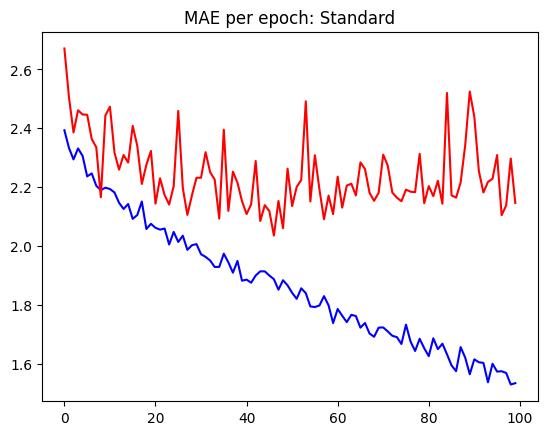

Mean Training MAE:  1.830373896360397
Mean Validation MAE:  2.4461058790153927


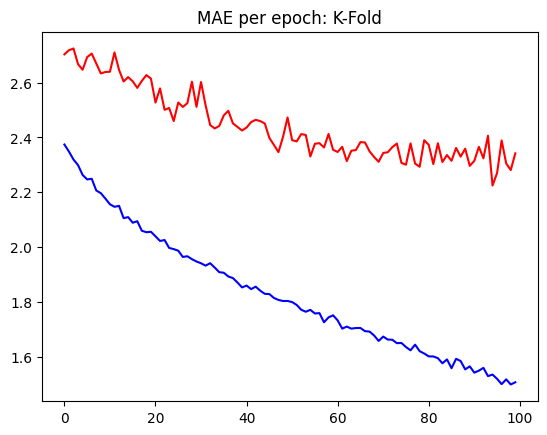

In [128]:
Common.get_history(standard_history.history, "Standard")
Common.get_history(kfold_history, "K-Fold")

**Evaluation**

In [129]:
get_evaluation(standard_model, "Standard")
get_evaluation(kfold_model, "K-Fold")

Mean Test MAE (Standard): 2.5501089096069336
Mean Test MAE (K-Fold): 2.517080783843994


**Prediction**

In [130]:
get_prediction(standard_model, "Standard")
get_prediction(kfold_model, "K-Fold")


Standard

Ground: 7.2 Predict: 7.762303352355957
Error: 0.5623033523559569

Ground: 18.8 Predict: 19.152864456176758
Error: 0.3528644561767571

Ground: 19.0 Predict: 21.361473083496094
Error: 2.3614730834960938


K-Fold

Ground: 7.2 Predict: 7.8391852378845215
Error: 0.6391852378845213

Ground: 18.8 Predict: 19.255168914794922
Error: 0.45516891479492116

Ground: 19.0 Predict: 21.73274803161621
Error: 2.732748031616211

